In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### **DATA PREPARATION**

In [3]:
dataset_dir = r'C:\Users\edwin\OneDrive - Bina Nusantara\PPTI - CAWU 3\Artificial Intelligence\project\KLASIFIKASI_UANG_KERTAS_RUPIAH\datasets'

filepaths = []
labels = []

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(class_path, filename)
                filepaths.append(file_path)
                labels.append(class_name)

df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

print(f"Total images: {len(df)}")
print("\nClass distribution:")
print(df['labels'].value_counts())

Total images: 10982

Class distribution:
labels
tujuh lima ribu    1550
lima puluh ribu    1415
sepuluh ribu       1394
dua ribu           1366
seratus ribu       1346
dua puluh ribu     1336
seribu             1288
lima ribu          1287
Name: count, dtype: int64


### **DATA SPLITTING**

In [4]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_df, temp_df = train_test_split(
    df, 
    train_size=train_ratio, 
    stratify=df['labels'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df, 
    train_size=val_ratio/(val_ratio + test_ratio), 
    stratify=temp_df['labels'],
    random_state=42
)

print(f"\nTraining set size   : {len(train_df)}")
print(f"Validation set size : {len(val_df)}")
print(f"Testing set size    : {len(test_df)}")


Training set size   : 8785
Validation set size : 1098
Testing set size    : 1099


### **DATA GENERATORS**

In [5]:
img_size = (224, 224)
batch_size = 32
img_shape = (*img_size, 3)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)
print("\nClasses:", class_names)

Found 8785 validated image filenames belonging to 8 classes.
Found 1098 validated image filenames belonging to 8 classes.
Found 1099 validated image filenames belonging to 8 classes.

Classes: ['dua puluh ribu', 'dua ribu', 'lima puluh ribu', 'lima ribu', 'sepuluh ribu', 'seratus ribu', 'seribu', 'tujuh lima ribu']


### **MODEL ARCHITECTURE**

In [6]:
modelnamefile = "best_model_mobilenetv2.h5"
finalnamefile = "final_model_mobilenetv2.h5"

def create_model():
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=img_shape,
        pooling='avg'
    )
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_model()

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 2587719 (9.87 MB)
Trainable params: 329735 (1.26 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### **MODEL COMPILE AND TRAINING**

In [7]:
save_dir = r'C:\Users\edwin\OneDrive - Bina Nusantara\PPTI - CAWU 3\Artificial Intelligence\project\KLASIFIKASI_UANG_KERTAS_RUPIAH\MODEL1 - MobileNetV2'

In [10]:
import pickle

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath=os.path.join(save_dir, modelnamefile),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    # ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.5,           # Reduce the learning rate by half
    #     patience=3,           # Wait for 3 epochs with no improvement
    #     min_lr=1e-6,          # Don't reduce below this learning rate
    #     verbose=1
    # )
]

# Training
epochs = 25
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

with open(os.path.join(save_dir, 'training-history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/25
275/275 [==============================] - ETA: 0s - loss: 1.4370 - accuracy: 0.4729
Epoch 1: val_accuracy improved from -inf to 0.65847, saving model to C:\Users\edwin\OneDrive - Bina Nusantara\PPTI - CAWU 3\Artificial Intelligence\project\KLASIFIKASI_UANG_KERTAS_RUPIAH\MODEL1 - MobileNetV2\best_model_mobilenetv2.h5


c:\Users\edwin\anaconda3\envs\ai-klasifikasi-mata-uang-rupiah\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 1117s 4s/step - loss: 1.4370 - accuracy: 0.4729 - val_loss: 0.9403 - val_accuracy: 0.6585
Epoch 2/25
275/275 [==============================] - ETA: 0s - loss: 0.9563 - accuracy: 0.6543
Epoch 2: val_accuracy improved from 0.65847 to 0.74044, saving model to C:\Users\edwin\OneDrive - Bina Nusantara\PPTI - CAWU 3\Artificial Intelligence\project\KLASIFIKASI_UANG_KERTAS_RUPIAH\MODEL1 - MobileNetV2\best_model_mobilenetv2.h5
275/275 [==============================] - 1053s 4s/step - loss: 0.9563 - accuracy: 0.6543 - val_loss: 0.7310 - val_accuracy: 0.7404
Epoch 3/25
275/275 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.7037
Epoch 3: val_accuracy improved from 0.74044 to 0.74772, saving model to C:\Users\edwin\OneDrive - Bina Nusantara\PPTI - CAWU 3\Artificial Intelligence\project\KLASIFIKASI_UANG_KERTAS_RUPIAH\MODEL1 - MobileNetV2\best_model_mobilenetv2.h5
275/275 [==============================] - 743s 3s/step - loss: 0.82

### **EVALUATING AND VISUALIZATION**

Test Accuracy: 0.8435
Test Loss: 0.4564


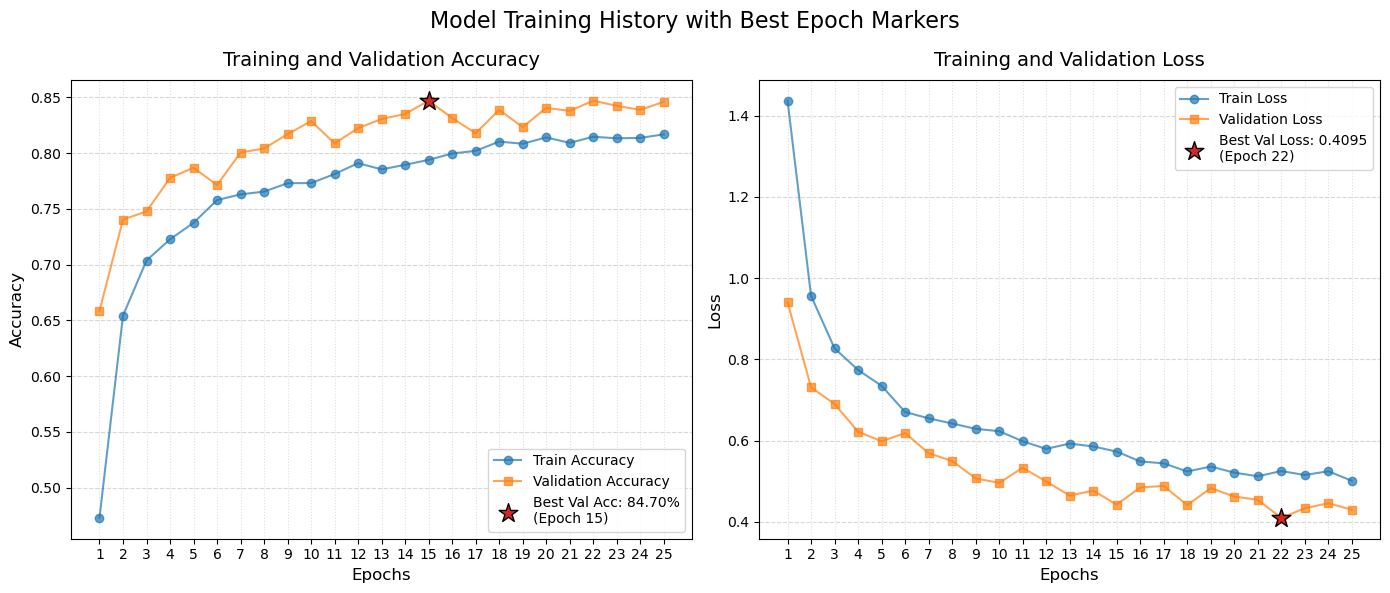

Best validation accuracy at epoch 15
Best validation loss at epoch 22
35/35 [==============================] - 45s 1s/step


In [11]:
import pickle

with open(os.path.join(save_dir, 'training-history.pkl'), 'rb') as f:
    history_dict = pickle.load(f)

class FakeHistory:
    def __init__(self, history):
        self.history = history

history = FakeHistory(history_dict)

model = models.load_model(os.path.join(save_dir, modelnamefile))

test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print("\033[1;32m" + f"Test Accuracy: {test_acc:.4f}" + "\033[0m")
print("\033[1;32m" + f"Test Loss: {test_loss:.4f}" + "\033[0m")

def plot_history(history):
    plt.figure(figsize=(14, 6))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    best_acc_epoch = np.argmax(val_acc) + 1
    best_loss_epoch = np.argmin(val_loss) + 1
    best_acc_value = val_acc[best_acc_epoch - 1]
    best_loss_value = val_loss[best_loss_epoch - 1]
    
    train_color = '#1f77b4'
    val_color = '#ff7f0e'
    best_marker_color = '#d62728'
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'o-', color=train_color, label='Train Accuracy', alpha=0.7)
    plt.plot(epochs, val_acc, 's-', color=val_color, label='Validation Accuracy', alpha=0.7)
    
    plt.scatter(best_acc_epoch, best_acc_value, s=200, 
                marker='*', color=best_marker_color, 
                zorder=10, edgecolor='black', 
                label=f'Best Val Acc: {best_acc_value:.2%}\n(Epoch {best_acc_epoch})')
    
    plt.title('Training and Validation Accuracy', fontsize=14, pad=10)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='lower right', frameon=True, facecolor='white')
    
    plt.xticks(epochs)
    plt.gca().xaxis.grid(True, which='major', linestyle=':', alpha=0.4)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'o-', color=train_color, label='Train Loss', alpha=0.7)
    plt.plot(epochs, val_loss, 's-', color=val_color, label='Validation Loss', alpha=0.7)
    
    plt.scatter(best_loss_epoch, best_loss_value, s=200,
                marker='*', color=best_marker_color,
                zorder=10, edgecolor='black',
                label=f'Best Val Loss: {best_loss_value:.4f}\n(Epoch {best_loss_epoch})')
    
    plt.title('Training and Validation Loss', fontsize=14, pad=10)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper right', frameon=True, facecolor='white')
    
    plt.xticks(epochs)
    plt.gca().xaxis.grid(True, which='major', linestyle=':', alpha=0.4)
    
    plt.suptitle('Model Training History with Best Epoch Markers', fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    return best_acc_epoch, best_loss_epoch

best_acc_epoch, best_loss_epoch = plot_history(history)
print(f"Best validation accuracy at epoch {best_acc_epoch}")
print(f"Best validation loss at epoch {best_loss_epoch}")


# DATA FOR CONFUSSION MATRIX AND CLASSIFICATION REPORT
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

#### EVALUATE - CONFUSSION MATRIX DIAGRAM

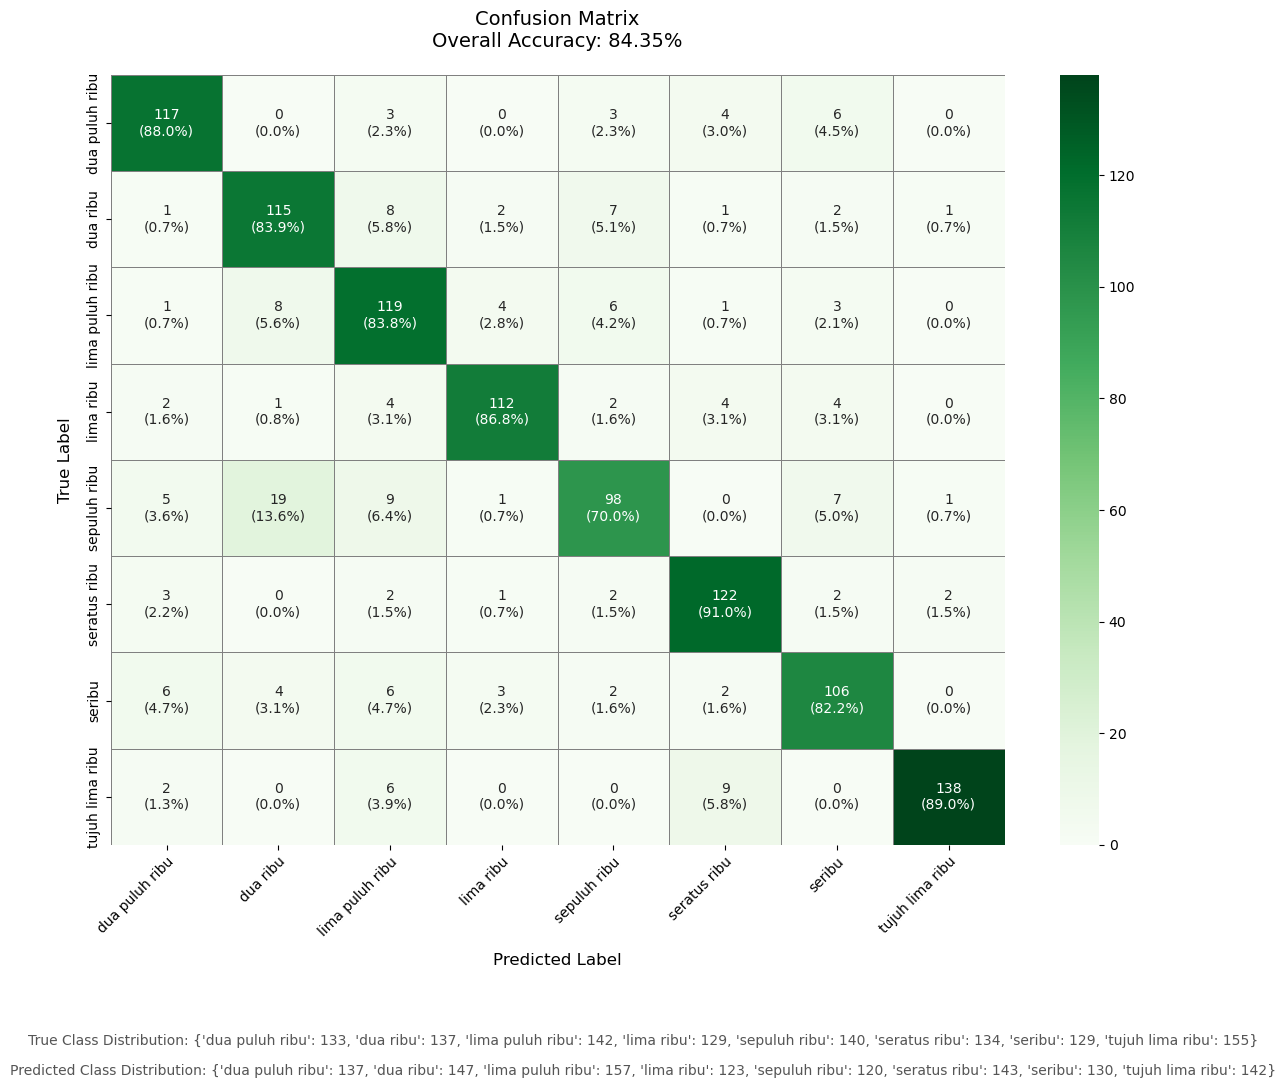

In [12]:
def plot_enhanced_confusion_matrix(y_true, y_pred, classes, 
                          title='Confusion Matrix', 
                          cmap='Greens', 
                          normalize=False, 
                          figsize=(12, 10)):

    fig = plt.figure(figsize=figsize)
    
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        vmax = 1.0
    else:
        fmt = 'd'
        vmax = cm.max()
    
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            if normalize:
                annot[i, j] = f"{cm[i, j]:.1%}\n({confusion_matrix(y_true, y_pred)[i, j]})"
            else:
                annot[i, j] = f"{cm[i, j]}\n({cm[i, j]/cm.sum(axis=1)[i]:.1%})"
    
    ax = plt.subplot()
    sns.heatmap(cm, annot=annot, fmt='', 
                cmap=cmap, vmin=0, vmax=vmax,
                cbar=True, linewidths=0.5, linecolor='gray',
                xticklabels=classes, yticklabels=classes,
                ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12, labelpad=10)
    ax.set_ylabel('True Label', fontsize=12, labelpad=10)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    accuracy = np.trace(cm) / np.sum(cm)
    ax.set_title(f"{title}\nOverall Accuracy: {accuracy:.2%}", fontsize=14, pad=20)
    
    for i in range(nrows):
        for j in range(ncols):
            if i != j and cm[i, j] > 0.7 * cm.max():
                ax.text(j + 0.5, i + 0.5, annot[i, j], 
                        ha="center", va="center", 
                        fontweight='bold', color='red',
                        bbox=dict(boxstyle="round,pad=0.3", fc='yellow', ec="black", alpha=0.5))
    
    plt.figtext(0.5, -0.05, 
                f"True Class Distribution: {dict(zip(classes, np.sum(cm, axis=1)))}",
                ha="center", fontsize=10, color='#555555')
    plt.figtext(0.5, -0.08, 
                f"Predicted Class Distribution: {dict(zip(classes, np.sum(cm, axis=0)))}",
                ha="center", fontsize=10, color='#555555')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

plot_enhanced_confusion_matrix(y_true, y_pred_classes, class_names)

#### EVALUATE - PRINT CLASSIFICATION REPORT

In [13]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))



Classification Report:
                 precision    recall  f1-score   support

 dua puluh ribu       0.85      0.88      0.87       133
       dua ribu       0.78      0.84      0.81       137
lima puluh ribu       0.76      0.84      0.80       142
      lima ribu       0.91      0.87      0.89       129
   sepuluh ribu       0.82      0.70      0.75       140
   seratus ribu       0.85      0.91      0.88       134
         seribu       0.82      0.82      0.82       129
tujuh lima ribu       0.97      0.89      0.93       155

       accuracy                           0.84      1099
      macro avg       0.85      0.84      0.84      1099
   weighted avg       0.85      0.84      0.84      1099



#### EVALUATE - PREDICT IMAGE

In [13]:
from tensorflow.keras.preprocessing import image

model = models.load_model(os.path.join(save_dir, modelnamefile))

img_path = r"../datasets/lima ribu/IMG20201220092601-removebg-preview.pnglantai.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = img_arr / 255.0

In [14]:
prediction = model.predict(img_arr)
predicted_class = np.argmax(prediction, axis=1)
print("Predicted class index:", predicted_class)

1/1 [==============================] - 6s 6s/step
Predicted class index: [3]


In [15]:
class_indices = test_gen.class_indices
labels = dict((v, k) for k, v in class_indices.items())
print("Predicted label:", labels[predicted_class[0]])

Predicted label: lima ribu


#### EVALUATE - MISCLASSIFIED CLASSES AND IMAGES

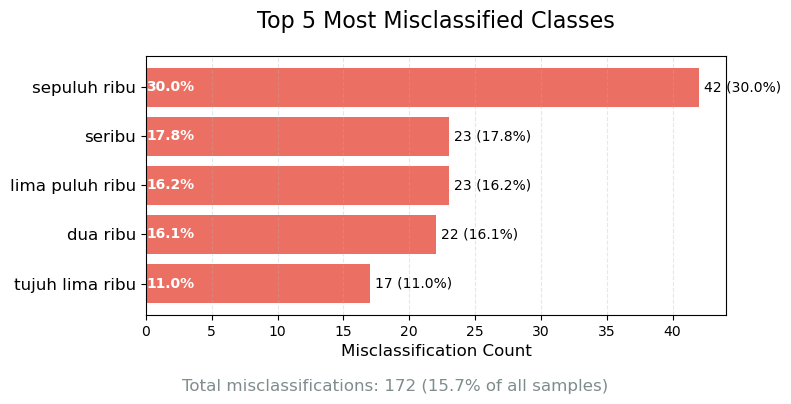

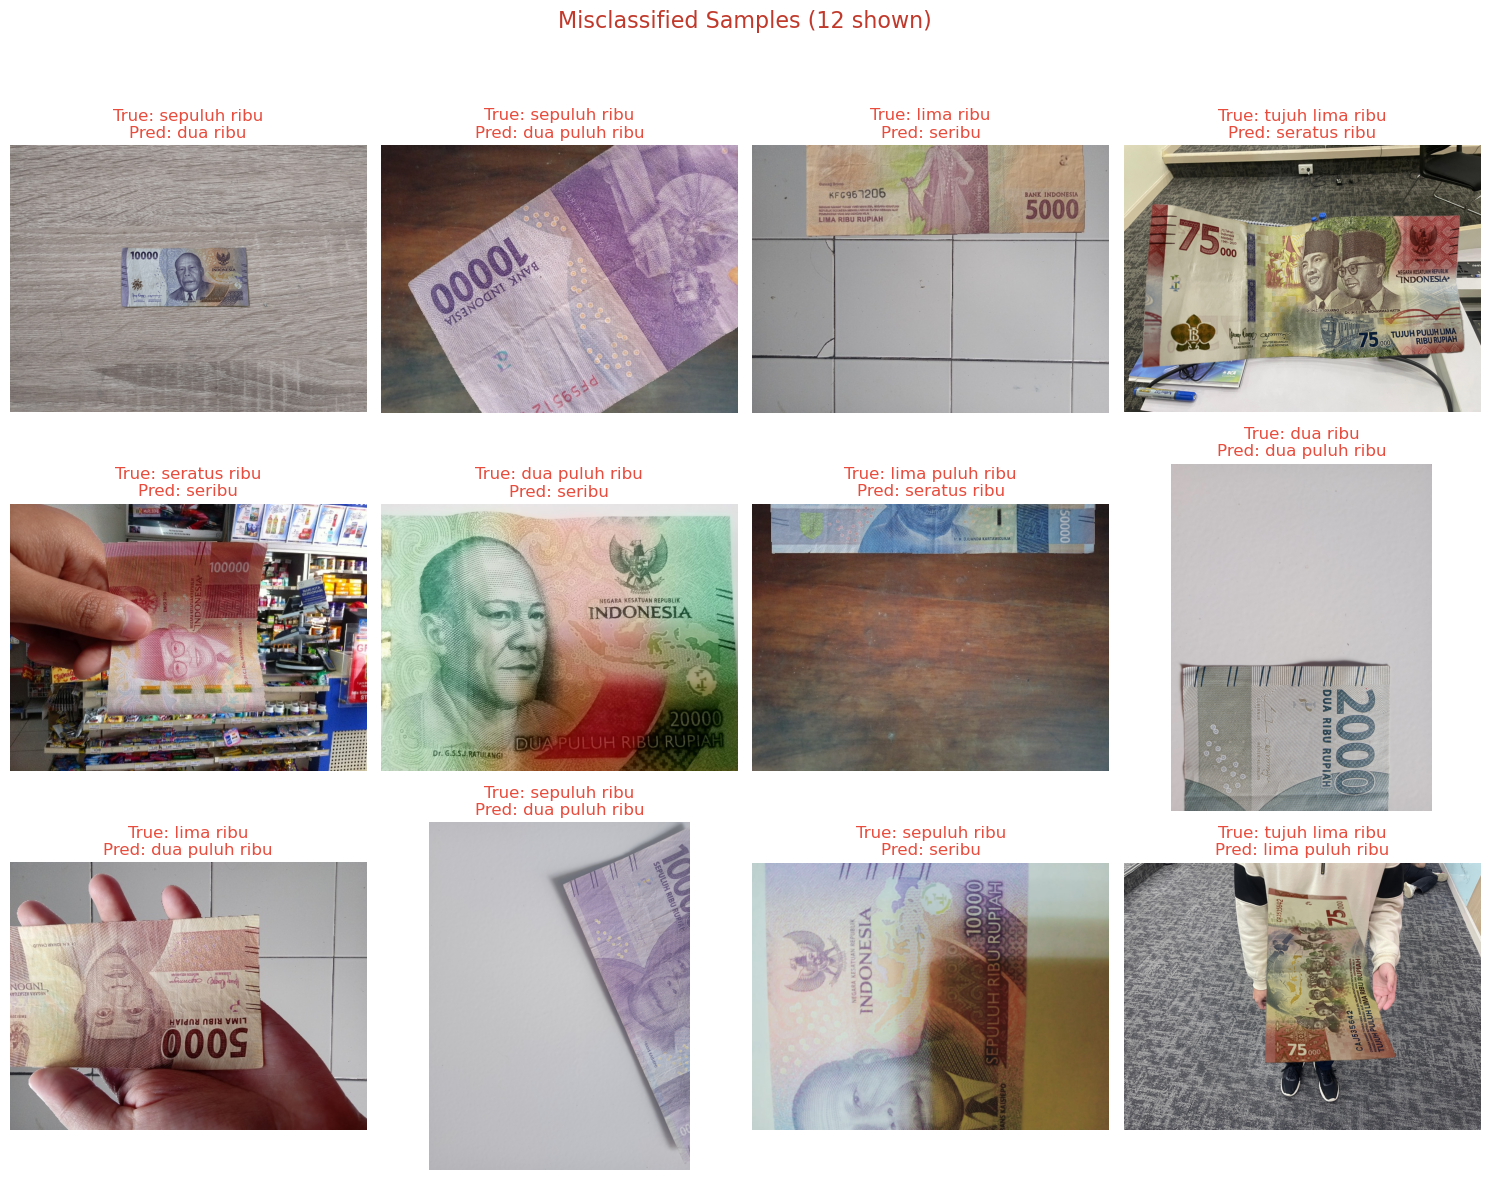

In [14]:
def plot_most_misclassified_classes(y_true, y_pred, class_names, top_n=10, figsize=(8, 4)):
    misclassified_counts = {}
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            class_name = class_names[true_label]
            misclassified_counts[class_name] = misclassified_counts.get(class_name, 0) + 1
    
    sorted_misclassified = sorted(misclassified_counts.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True)[:top_n]
    
    classes = [item[0] for item in sorted_misclassified]
    counts = [item[1] for item in sorted_misclassified]
    
    class_counts = np.bincount(y_true)
    rates = [count / class_counts[class_names.index(cls)] for cls, count in sorted_misclassified]
    
    plt.figure(figsize=figsize)
    ax = plt.subplot()
    
    y_pos = np.arange(len(classes))
    bars = ax.barh(y_pos, counts, color='#e74c3c', alpha=0.8)
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                f'{counts[i]} ({rates[i]:.1%})',
                va='center', ha='left', fontsize=10)
    
    for i, rate in enumerate(rates):
        ax.text(0.01, i, f'{rate:.1%}', 
                va='center', ha='left', color='white', fontweight='bold')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes, fontsize=12)
    ax.invert_yaxis()
    ax.set_xlabel('Misclassification Count', fontsize=12)
    ax.set_title(f'Top {top_n} Most Misclassified Classes', fontsize=16, pad=20)
    
    ax.xaxis.grid(True, linestyle='--', alpha=0.3)
    
    total_misclassified = sum(misclassified_counts.values())
    plt.figtext(0.5, 0.01, 
                f"Total misclassifications: {total_misclassified} ({total_misclassified/len(y_true):.1%} of all samples)",
                ha="center", fontsize=12, color='#7f8c8d')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.20)
    plt.show()

def show_misclassified_image_samples(test_gen, y_true, y_pred, class_names, 
                                    num_samples=12, figsize=(15, 12), 
                                    seed=42):
    
    misclassified_indices = np.where(y_true != y_pred)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return
    
    np.random.seed(seed)
    selected_indices = np.random.choice(misclassified_indices, 
                                       size=min(num_samples, len(misclassified_indices)), 
                                       replace=False)
    
    plt.figure(figsize=figsize)
    
    cols = 4
    rows = int(np.ceil(num_samples / cols))
    
    for i, idx in enumerate(selected_indices):
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        
        ax = plt.subplot(rows, cols, i+1)
        
        plt.imshow(img)
        plt.axis('off')
        
        title = f"True: {true_label}\nPred: {pred_label}"
        plt.title(title, fontsize=12, color='#e74c3c' if true_label != pred_label else '#2ecc71')
        
        for spine in ax.spines.values():
            spine.set_edgecolor('#e74c3c')
            spine.set_linewidth(2)
    
    plt.suptitle(f"Misclassified Samples ({len(selected_indices)} shown)", 
                 fontsize=16, y=0.98, color='#c0392b')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


plot_most_misclassified_classes(y_true, y_pred_classes, class_names, top_n=5)

show_misclassified_image_samples(test_gen, y_true, y_pred_classes, class_names, 
                                num_samples=12, seed=42)

### **SAVE MISCLASSIFIED SAMPLES**

In [ ]:
def save_misclassified_samples(test_gen, y_true, y_pred_classes, class_names, save_dir):
    """Save misclassified images for manual review"""
    misclassified_indices = np.where(y_true != y_pred_classes)[0]
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i, idx in enumerate(misclassified_indices[:20]): 
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)
        
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred_classes[idx]]
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
        plt.axis('off')
        
        save_path = os.path.join(save_dir, f"misclassified_{i+1}.png")
        plt.savefig(save_path, bbox_inches='tight', dpi=100)
        plt.close()
    
    print(f"Saved {min(20, len(misclassified_indices))} misclassified samples to {save_dir}")

save_misclassified_samples(
    test_gen, 
    y_true, 
    y_pred_classes,     
    class_names,
    os.path.join(save_dir, 'misclassified_samples')
)

Saved 20 misclassified samples to C:\Users\edwin\OneDrive - Bina Nusantara\PPTI - CAWU 3\Artificial Intelligence\project\KLASIFIKASI_UANG_KERTAS_RUPIAH\misclassified_samples


### **SAVE FINAL MODEL**

In [15]:
model.save(os.path.join(save_dir, finalnamefile))
print("Model saved successfully!")

class_mapping = {v: k for k, v in train_gen.class_indices.items()}
np.save(os.path.join(save_dir, 'class_mapping.npy'), class_mapping)
print("Class mapping saved.")

c:\Users\edwin\anaconda3\envs\ai-klasifikasi-mata-uang-rupiah\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!
Class mapping saved.
